In [1]:
import cv2,os

data_path='D://face mask detection//data'
categories=os.listdir(data_path)
print(categories)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

print(label_dict)
print(categories)
print(labels)

['without_mask', 'with_mask']
{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [15]:

img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        #print(img_name)
        img_path=os.path.join(folder_path,img_name)
        #print(img_path)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            #print(label_dict[category])
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)

In [16]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

In [17]:
data.shape, target.shape

((1376, 100, 100, 1), (1376,))

In [18]:
target

array([0, 0, 0, ..., 1, 1, 1])

In [19]:
np.save('target',new_target)
np.save('data',data)

In [20]:
import numpy as np

data=np.load('data.npy')
target=np.load('target.npy')

In [21]:

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [22]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.2)

In [23]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Train on 880 samples, validate on 220 samples
Epoch 1/20
880/880 [==============================] - 32s 36ms/step - loss: 0.7408 - accuracy: 0.4909 - val_loss: 0.6814 - val_accuracy: 0.5591
Epoch 2/20
880/880 [==============================] - 31s 35ms/step - loss: 0.6617 - accuracy: 0.6011 - val_loss: 0.5696 - val_accuracy: 0.7636
Epoch 3/20
880/880 [==============================] - 31s 36ms/step - loss: 0.5091 - accuracy: 0.7545 - val_loss: 0.4356 - val_accuracy: 0.8500
Epoch 4/20
880/880 [==============================] - 32s 37ms/step - loss: 0.3667 - accuracy: 0.8511 - val_loss: 0.3015 - val_accuracy: 0.8955
Epoch 5/20
880/880 [==============================] - 32s 36ms/step - loss: 0.2471 - accuracy: 0.9057 - val_loss: 0.3428 - val_accuracy: 0.8636
Epoch 6/20
880/880 [==============================] - 32s 36ms/step - loss: 0.1932 - accuracy: 0.9239 - val_loss: 0.2102 - val_accuracy: 0.9364
Epoch 7/20
880/880 [==============================] - 32s 37ms/step - loss: 0.1129 - accur

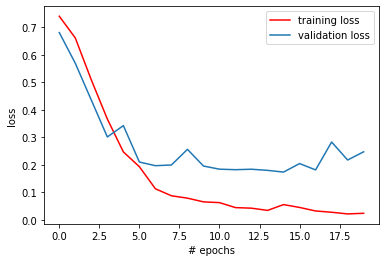

In [24]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

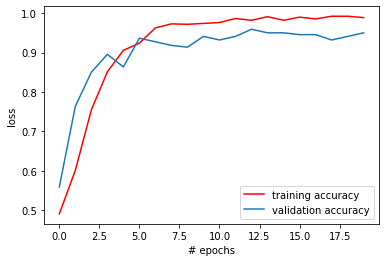

In [25]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [26]:
from keras.models import load_model
import cv2
import numpy as np

In [36]:
model = load_model('model-017.model')

face_clsfr=cv2.CascadeClassifier('D://face mask detection//haarcascade_frontalface_default.xml')
#eye_cascade=cv2.CascadeClassifier('D://face mask detection//haarcascade_eye.xml')

source=cv2.VideoCapture(0)

labels_dict={0:'NO MASK',1:'MASK'}
color_dict={0:(0,0,255),1:(0,255,0)}

In [37]:
while(True):

    ret,img=source.read()
    print(img)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  
    if(len(face)==0)

    for (x,y,w,h) in faces:
        
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()

[[[106 111 111]
  [111 116 115]
  [114 120 122]
  ...
  [151 155 155]
  [154 158 160]
  [156 161 162]]

 [[107 114 113]
  [111 118 118]
  [115 122 121]
  ...
  [152 157 154]
  [153 158 157]
  [156 161 161]]

 [[108 115 112]
  [111 119 116]
  [117 127 126]
  ...
  [153 158 155]
  [153 158 155]
  [155 160 158]]

 ...

 [[ 60  70  78]
  [ 60  70  78]
  [ 62  71  81]
  ...
  [101 108 105]
  [102 110 105]
  [103 111 106]]

 [[ 60  70  78]
  [ 59  69  77]
  [ 59  69  77]
  ...
  [ 97 107 104]
  [100 110 106]
  [100 110 106]]

 [[ 61  69  77]
  [ 59  66  75]
  [ 56  65  75]
  ...
  [ 99 108 107]
  [100 110 106]
  [100 110 106]]]
[[[110 119 122]
  [110 119 122]
  [108 120 128]
  ...
  [153 160 161]
  [153 160 159]
  [152 159 158]]

 [[111 117 121]
  [114 119 123]
  [109 119 125]
  ...
  [152 158 160]
  [151 158 157]
  [151 158 157]]

 [[111 117 121]
  [114 119 123]
  [115 120 126]
  ...
  [151 158 157]
  [150 157 156]
  [151 158 157]]

 ...

 [[ 65  69  80]
  [ 65  69  80]
  [ 66  70  83]
  ..

In [ ]:
acc=round(np.max(result,axis=1)[0]*100,2)
cv2.putText(img, str(acc), (x+150, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2) after cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)

In [43]:
data_path = 'C://Users//admin//Pictures//Camera Roll'
img_name = 'without mask.jpg'
img_path = img_path=os.path.join(data_path,img_name)
print(img_path)
img=cv2.imread(img_path)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(gray)
faces=face_clsfr.detectMultiScale(gray,1.3,5)
print(faces)
if(len(faces)==0):
    print('mask')
else:
    for (x,y,w,h) in faces:
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        #print('normalized')
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)
        #print(result)
        label=np.argmax(result,axis=1)
        #print(label)
        print('no mask')


C://Users//admin//Pictures//Camera Roll\with mask.jpg
[[136 130 123 ... 168 168 169]
 [119 118 118 ... 167 168 169]
 [110 113 116 ... 165 166 167]
 ...
 [ 48  45  42 ...  16  17  18]
 [ 49  47  45 ...  16  17  18]
 [ 49  49  49 ...  16  17  18]]
()
mask


In [15]:
model.evaluate(test_data,test_target)

276/276 [==============================] - 10s 36ms/step


[0.08329655902217263, 0.9746376872062683]

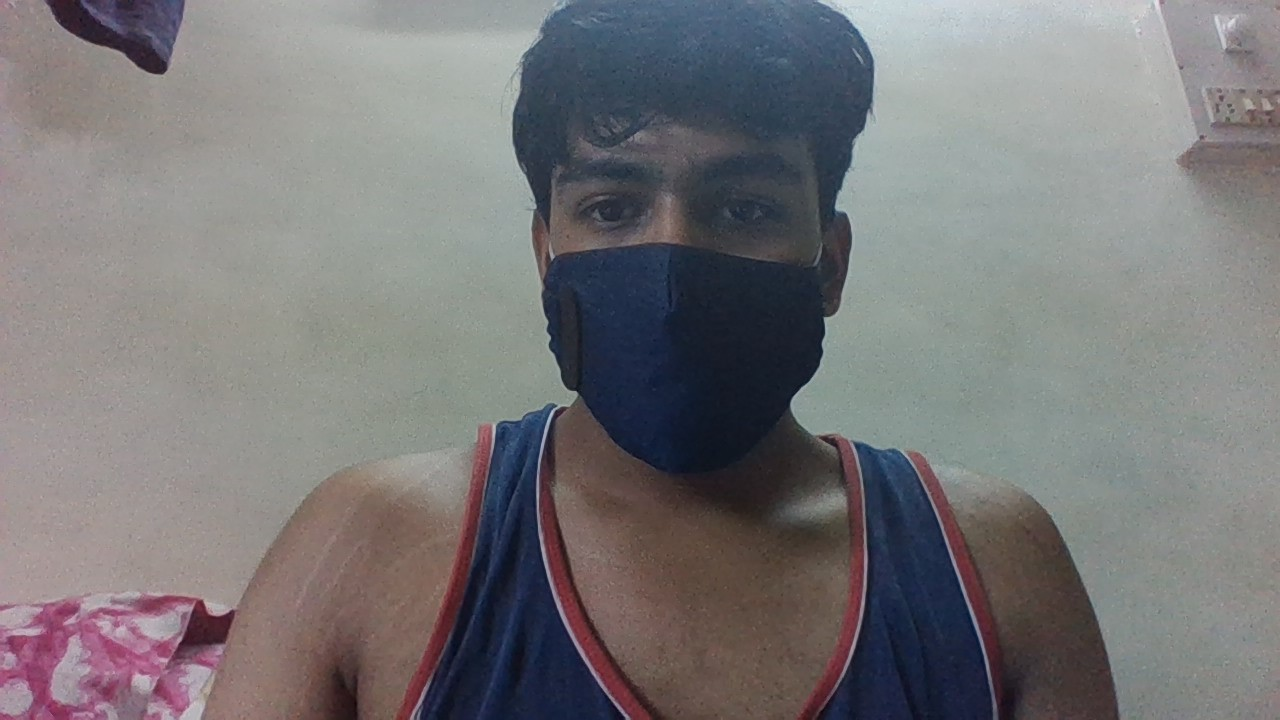

In [49]:
from IPython.display import Image
Image(filename="Pictures//Camera Roll//WIN_20200612_12_16_38_Pro.jpg")

In [40]:
data_path='Pictures//Camera Roll'
categories=os.listdir(data_path)
print(categories)

['desktop.ini', 'WIN_20200519_17_50_27_Pro.jpg', 'WIN_20200519_17_51_35_Pro.jpg']


In [68]:
face_cascade=cv2.CascadeClassifer('D://face mask detection///haarcasscade_frontalface_default.xml')
eye_cascade=cv2.CascadeClassifier('D://face mask detection//haarcascade_eye.xml')
data_path = 'C://Users//admin//Pictures//Camera Roll'
img_name = 'WIN_20200612_12_16_38_Pro.jpg'
#img_name = 'WIN_20200519_17_50_27_Pro.jpg'
img_path = img_path=os.path.join(data_path,img_name)
#print(img_path)
img=cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imshow(img)

AttributeError: module 'cv2.cv2' has no attribute 'CascadeClassifer'